# Behavioral data: Sanity checks

Natalia Vélez, August 2021

In [1]:
%matplotlib inline

import glob, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('white')

# helper function
def str_extract(pattern, s): return re.search(pattern, s).group(0)
def int_extract(pattern, s): return int(str_extract(pattern, s))

Find behavioral files for the teaching task:

In [2]:
teaching_files = glob.glob('../../behavioral/*.json')
teaching_files = [f for f in teaching_files if 'run-practice' not in f]
teaching_files.sort()

print('%i files found' % len(teaching_files))
print(*teaching_files[:20], sep='\n')
print('...')

299 files found
../../behavioral/sub-01_task-teaching_run-01_behavioral_1628798255.json
../../behavioral/sub-01_task-teaching_run-02_behavioral_1628798680.json
../../behavioral/sub-01_task-teaching_run-03_behavioral_1628799162.json
../../behavioral/sub-01_task-teaching_run-04_behavioral_1628800012.json
../../behavioral/sub-01_task-teaching_run-05_behavioral_1628800423.json
../../behavioral/sub-01_task-teaching_run-06_behavioral_1628800796.json
../../behavioral/sub-01_task-teaching_run-07_behavioral_1628801177.json
../../behavioral/sub-01_task-teaching_run-08_behavioral_1628801584.json
../../behavioral/sub-01_task-teaching_run-09_behavioral_1628802076.json
../../behavioral/sub-01_task-teaching_run-10_behavioral_1628802432.json
../../behavioral/sub-02_task-teaching_run-01_behavioral_1628805799.json
../../behavioral/sub-02_task-teaching_run-02_behavioral_1628806247.json
../../behavioral/sub-02_task-teaching_run-03_behavioral_1628806617.json
../../behavioral/sub-02_task-teaching_run-04_beh

Find behavioral files for the Theory of Mind localizer:

In [3]:
tomloc_files = glob.glob('../../tomloc/*.mat')
tomloc_files.sort()

print('%i files found' % len(tomloc_files))
print(*tomloc_files[:20], sep='\n')
print('...')

59 files found
../../tomloc/teaching_01.tom_localizer.1.mat
../../tomloc/teaching_01.tom_localizer.2.mat
../../tomloc/teaching_02.tom_localizer.1.mat
../../tomloc/teaching_02.tom_localizer.2.mat
../../tomloc/teaching_03.tom_localizer.1.mat
../../tomloc/teaching_04.tom_localizer.1.mat
../../tomloc/teaching_04.tom_localizer.2.mat
../../tomloc/teaching_05.tom_localizer.1.mat
../../tomloc/teaching_05.tom_localizer.2.mat
../../tomloc/teaching_06.tom_localizer.1.mat
../../tomloc/teaching_06.tom_localizer.2.mat
../../tomloc/teaching_07.tom_localizer.1.mat
../../tomloc/teaching_07.tom_localizer.2.mat
../../tomloc/teaching_08.tom_localizer.1.mat
../../tomloc/teaching_08.tom_localizer.2.mat
../../tomloc/teaching_09.tom_localizer.1.mat
../../tomloc/teaching_09.tom_localizer.2.mat
../../tomloc/teaching_10.tom_localizer.1.mat
../../tomloc/teaching_10.tom_localizer.2.mat
../../tomloc/teaching_11.tom_localizer.1.mat
...


## Teaching task

How many behavioral files per participant?

In [4]:
teaching_counts = pd.DataFrame({'teaching': teaching_files})
teaching_counts['subject'] = teaching_counts.teaching.str.extract('(sub-[0-9]{2})')
teaching_counts = teaching_counts.groupby('subject')['teaching'].agg('count').reset_index()
teaching_counts

,subject,teaching
0,sub-01,10
1,sub-02,10
2,sub-03,9
3,sub-04,10
4,sub-05,10
5,sub-06,10
6,sub-07,10
7,sub-08,10
8,sub-09,10
9,sub-10,10


Data wrangling:

In [5]:
run_list = []

for f in teaching_files:

    # load file
    sub = int_extract('(?<=sub-)([0-9]+)', f)
    run = int_extract('(?<=sub-)([0-9]+)', f)
    run_data = pd.read_json(f)
    run_data['subject'] = sub
    run_data['run'] = run

    # choose trials
    run_choose = run_data[run_data.type == 'choose']
    run_choose = run_choose[['subject', 'run', 'problem_idx', 'ex_idx', 'ons', 'problem', 'order', 'example']]
    run_choose

    # rate trials
    run_rate = run_data[run_data.type == 'rate']
    run_rate = run_rate[['subject', 'run', 'problem_idx', 'ex_idx', 'rating']]

    # merge
    clean_data = run_choose.merge(run_rate)
    clean_data = clean_data.rename(columns={'ons': 'onset'})
    run_list.append(clean_data)
    
teaching_data = pd.concat(run_list)
print(teaching_data.shape)
teaching_data.head()

(3588, 9)


,subject,run,problem_idx,ex_idx,onset,problem,order,example,rating
0,1,1,0.0,0.0,30.00,22.0,"[C, B, D, A]","[1, 2]",1.0
1,1,1,0.0,1.0,45.35,22.0,"[C, B, D, A]","[4, 3]",2.0
2,1,1,0.0,2.0,59.35,22.0,"[C, B, D, A]",None,2.0
3,1,1,1.0,0.0,104.05,18.0,"[D, B, C, A]","[0, 3]",0.0
4,1,1,1.0,1.0,118.45,18.0,"[D, B, C, A]","[5, 2]",NaN


Number of successful trials:

In [6]:
teaching_summ = teaching_data.groupby('subject')[['example', 'rating']].agg('count').reset_index()

# merge with number of runs
teaching_summ['subject'] = teaching_summ['subject'].apply(lambda s: 'sub-%02d' % s)
teaching_summ = teaching_summ.merge(teaching_counts)
teaching_summ = teaching_summ.rename(columns={'teaching': 'n_runs'})

teaching_summ['pct_example'] = teaching_summ.example/(12*teaching_summ.n_runs)*100
teaching_summ['pct_rating'] = teaching_summ.rating/(12*teaching_summ.n_runs)*100
teaching_summ

,subject,example,rating,n_runs,pct_example,pct_rating
0,sub-01,108,112,10,90.000000,93.333333
1,sub-02,114,116,10,95.000000,96.666667
2,sub-03,93,96,9,86.111111,88.888889
3,sub-04,113,114,10,94.166667,95.000000
4,sub-05,114,120,10,95.000000,100.000000
5,sub-06,115,119,10,95.833333,99.166667
6,sub-07,118,118,10,98.333333,98.333333
7,sub-08,119,116,10,99.166667,96.666667
8,sub-09,116,120,10,96.666667,100.000000
9,sub-10,112,118,10,93.333333,98.333333


In [7]:
teaching_summ[['pct_example', 'pct_rating']].agg(['min', 'max', 'mean'])

,pct_example,pct_rating
min,83.333333,79.166667
max,100.000000,100.000000
mean,95.259259,96.712963


[Text(0.5, 0, '% examples provided (out of max)')]

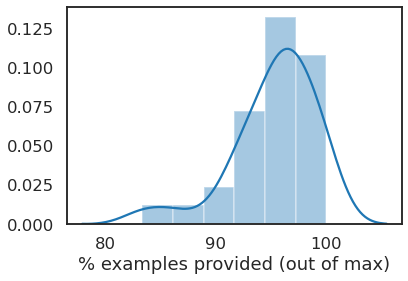

In [8]:
ax = sns.distplot(teaching_summ.pct_example)
ax.set(xlabel='% examples provided (out of max)')

[Text(0.5, 0, '% ratings provided (out of max)')]

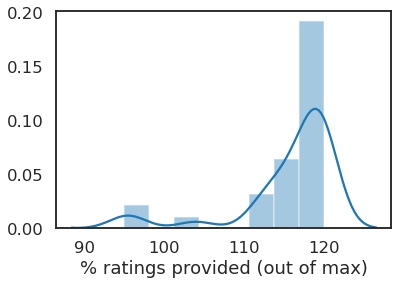

In [9]:
ax = sns.distplot(teaching_summ.rating)
ax.set(xlabel='% ratings provided (out of max)')

Save outputs to file

In [10]:
teaching_data.to_csv('outputs/teaching_behavior.csv', index=False)
teaching_summ.to_csv('outputs/teaching_compliance.csv', index=False)

## Theory of Mind localizer

How many behavioral files per participant?

In [11]:
tomloc_counts = pd.DataFrame({'tomloc': tomloc_files})
tomloc_counts['subject'] = tomloc_counts.tomloc.str.extract('(teaching_[0-9]{2})')
tomloc_counts = tomloc_counts.groupby('subject')['tomloc'].agg('count')
tomloc_counts

subject
teaching_01    2
teaching_02    2
teaching_03    1
teaching_04    2
teaching_05    2
teaching_06    2
teaching_07    2
teaching_08    2
teaching_09    2
teaching_10    2
teaching_11    2
teaching_12    2
teaching_13    2
teaching_14    2
teaching_15    2
teaching_16    2
teaching_17    2
teaching_18    2
teaching_19    2
teaching_20    2
teaching_21    2
teaching_22    2
teaching_23    2
teaching_24    2
teaching_25    2
teaching_26    2
teaching_27    2
teaching_28    2
teaching_29    2
teaching_30    2
Name: tomloc, dtype: int64